In [1]:
 """
 NOTE
 Must go to Command Pallette (Cmd/Ctrl+Shift+P) and enter "Use Fallback Runtime" to enable running older python
 """
 ! pip install cloud-tpu-client==0.10.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.0
    Uninstalling google-api-core-2.11.0:
      Successfully uninstalled google-api-core-2.11.0
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account

In [2]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.3 MB/s eta 0:00:00


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.0 MB/s eta 0:00:00


In [4]:
# intall tools for pulling Supreme Court Arguments transcripts 
# !pip3 install convokit
# !python3 -m spacy download en_core_web_sm

In [5]:
import pandas as pd
import nltk

# Rather than load Corpus, we load the transcripts csv separately 
# from convokit import Corpus, download

In [6]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [8]:
import torch_xla.core.xla_model as xm

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import BigBirdModel, BigBirdTokenizerFast
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [10]:
device = xm.xla_device()

In [11]:
martin_quinn = pd.read_csv('/content/drive/MyDrive/INFO251Final/MartinQuinnScores.csv')

Our first attempt involved creating full transcripts for each case and exporting them as CSVs, which we then loaded into the script as needed. This exceeded the memory limits of Google Colab's TPUs and GPUs during training. 

We then tried a similar process but with the the "utterance" transcripts -- essentially lengths of text spoken by one person. Here, however, the RAM limit was exceeded when using the package that creates the utterance objects. We do not know why the RAM was exceeded here given that we were able to run the package locally on machines with lower amounts of RAM. 

Our third attempt was to create a dataframe of all utterances and the associated text and export it as a csv, roughly 1.7 million lines and 0.6GB as opposed to the packages ~7.3GB. 

In [44]:
# create dataframe of utterances by case
df_utt = pd.read_csv('/content/drive/MyDrive/INFO251Final/Utterances_DataFrame.csv')

<ipython-input-44-1df88e88c522>:2: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_utt = pd.read_csv('/content/drive/MyDrive/INFO251Final/Utterances_DataFrame.csv')


In [45]:
df_utt.head()

,Unnamed: 0,timestamp,text,speaker,reply_to,convo_id,case_id,meta.start_times,meta.stop_times,meta.speaker_type,meta.side,meta.timestamp,vectors,utt_id,term,docket_id,mq_score
0,0,NaN,"Number 71, Lonnie Affronti versus United State...",j__earl_warren,NaN,13127,1955_71,"[0.0, 7.624]","[7.624, 9.218]",J,NaN,0.000,[],13127__0_000,1955,71,0.559
1,1,NaN,May it please the Court.\nWe are here by writ ...,harry_f_murphy,13127__0_000,13127,1955_71,"[9.218, 11.538, 15.653, 22.722, 28.849, 33.575]","[11.538, 15.653, 22.722, 28.849, 33.575, 48.138]",A,1.0,9.218,[],13127__0_001,1955,71,0.559
2,2,NaN,Consecutive sentences.,j__william_o_douglas,13127__0_001,13127,1955_71,[48.138],[49.315],J,NaN,48.138,[],13127__0_002,1955,71,0.559
3,3,NaN,"Consecutive sentences.\nIn this case, the defe...",harry_f_murphy,13127__0_002,13127,1955_71,"[49.315, 51.844, 60.81, 67.083, 72.584, 89.839...","[51.844, 60.81, 67.083, 72.584, 89.839, 95.873...",A,1.0,49.315,[],13127__0_003,1955,71,0.559
4,4,NaN,Was the aggregate prison sentence was 20 or 25...,<INAUDIBLE>,13127__0_003,13127,1955_71,[174.058],[176.766],NaN,NaN,174.058,[],13127__0_004,1955,71,0.559


In [46]:

# updating columns

# rename columns
df_utt = df_utt.rename(columns={'meta.votes_side': 'votes_side',
                                  'meta.win_side': 'win_side',
                                  'meta.case_id': 'case_id',
                                  'med': 'mq_score', 
                                   'conversation_id': 'convo_id',
                                  'term_year': 'term'})

df_utt.term = df_utt.term.astype('int64')
# add MartinQuinn Scores
df_utt = df_utt.merge(martin_quinn[['term', 'med']], on='term')

# drop unused columns
# NOTE we may want to try an analysis on some of these later on
df_utt = df_utt.drop(columns=['speaker', 
                              'reply_to', 
                              'timestamp', 
                              'meta.start_times', 
                              'meta.stop_times', 
                              'meta.speaker_type',
                              'meta.side',
                              'meta.timestamp',
                              'vectors',
                              'Unnamed: 0'])




In [47]:
df_utt.head()

,text,convo_id,case_id,utt_id,term,docket_id,mq_score,med
0,"Number 71, Lonnie Affronti versus United State...",13127,1955_71,13127__0_000,1955,71,0.559,0.559
1,May it please the Court.\nWe are here by writ ...,13127,1955_71,13127__0_001,1955,71,0.559,0.559
2,Consecutive sentences.,13127,1955_71,13127__0_002,1955,71,0.559,0.559
3,"Consecutive sentences.\nIn this case, the defe...",13127,1955_71,13127__0_003,1955,71,0.559,0.559
4,Was the aggregate prison sentence was 20 or 25...,13127,1955_71,13127__0_004,1955,71,0.559,0.559


In [48]:
df_convo = pd.read_csv('/content/drive/MyDrive/INFO251Final/Outcomes_NoTranscript.csv')

In [49]:
df_convo.head()

,Unnamed: 0,vectors,case_id,advocates,win_side,votes_side,convo_id,term,docket_id,mq_score
0,0,[],1955_71,"{'harry_f_murphy': {'side': 1, 'role': 'inferr...",0.0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13127,1955,71,0.559
1,1,[],1955_410,"{'howard_c_westwood': {'side': 1, 'role': 'inf...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",12997,1955,410,0.559
2,2,[],1955_410,"{'howard_c_westwood': {'side': 1, 'role': 'inf...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",13024,1955,410,0.559
3,3,[],1955_351,"{'harry_d_graham': {'side': 3, 'role': 'inferr...",1.0,"{'j__john_m_harlan2': 1, 'j__hugo_l_black': 1,...",13015,1955,351,0.559
4,4,[],1955_38,"{'robert_n_gorman': {'side': 3, 'role': 'infer...",0.0,"{'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...",13016,1955,38,0.559


In [50]:
# add "win_side" to utterance dataframe

df_utt = df_utt.merge(df_convo[['convo_id', 'win_side']], on='convo_id')


In [51]:
df_utt.drop(columns=['Unnamed: 0'])

KeyError: ignored

In [ ]:
df_utt = df_utt.rename(columns={'text': 'words'})

In [ ]:
df_utt.head()

In [ ]:
# Remove instances where case outcome was unknown or ????
df_utt.drop(df_utt[df_utt['win_side'] == -1.0].index, inplace = True)
df_utt.drop(df_utt[df_utt['win_side'] == 2.0].index, inplace = True)

In [ ]:
df_utt['win_side'].value_counts()

In [ ]:
df_utt.isnull().sum()

In [ ]:
df_utt = df_utt.dropna()

In [ ]:
df_utt.isnull().sum()

In [ ]:
#  ATTENTION

sample_size = 50000

# Set this value before continuing
df_test = df_utt.sample(n=sample_size, replace=False, random_state=123)

In [ ]:
##### Delete for now
del(df_utt)

In [52]:
### Use when pulling transcripts by conversation files

# rename text to words
# df_test['words'] = np.nan

In [53]:
# pull transcripts for each utterance per conversation and store in "words" column
# This method separately creates the transcripts for each conversation and stores them in a 
# separate folder for reference. Although this allowed for easy grouping by case, it 
# overwhelmed memory allocations 

# for index, row in df_test.iterrows():

    # folder_path = '/content/drive/MyDrive/INFO251Final/Trancripts_uttid_caseid/'
    # read_path = folder_path+str(row['utt_id'])+'_'+str(row['case_id'])+'.txt'

    # text = transcript.read(read_path)
    # transcript.close()

    

In [54]:
# df_test = df_test.dropna()
# df_test.isnull().any()

In [55]:
# df_test['win_side']

In [56]:
# convert to int for later reference by language models 
df_test['win_side'] = df_test['win_side'].astype(int)

In [57]:
import gc
gc.collect()

44

In [58]:
# Run train test split with conversation grouping 
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=123)

In [59]:
# create train and temp split. Temp split will be split in half into testing and validation sets
for train_idx, test_idx in gss.split(df_test, groups=df_test['convo_id']):
    train_df = df_test.iloc[train_idx]
    temp_df = df_test.iloc[test_idx]

In [60]:
train_df.sort_values(by=['convo_id'])

,words,convo_id,case_id,utt_id,term,docket_id,mq_score,med,win_side
3337,(Voice Overlap),12990,1955_48,12990__1_037,1955,48,0.559,0.559,1
3306,Only after the judgment of this Court.,12990,1955_48,12990__1_006,1955,48,0.559,0.559,1
3238,That fact may be used by the prosecutor as a l...,12990,1955_48,12990__0_057,1955,48,0.559,0.559,1
3336,"Well, -- either I --",12990,1955_48,12990__1_036,1955,48,0.559,0.559,1
30236,This milk -- this milk were being processed or...,12993,1955_13-orig,12993__0_006,1955,13-orig,0.559,0.559,0
...,...,...,...,...,...,...,...,...,...
1688496,"Okay.\nThat's not -- that's not correct, becau...",25053,2019_17-1618,25053__0_112,2019,17-1618,0.355,0.355,1
1688440,-- beg the question.,25053,2019_17-1618,25053__0_056,2019,17-1618,0.355,0.355,1
1688539,No --,25053,2019_17-1618,25053__1_031,2019,17-1618,0.355,0.355,1
1688411,-- or we can talk real world examples.,25053,2019_17-1618,25053__0_027,2019,17-1618,0.355,0.355,1


In [61]:
# #####
"""
Block used for convo grouping method
"""

# split train dataset into train, validation and test sets
# train_text, temp_text, train_labels, temp_labels = train_test_split(df_test['words'], 
#                                                                     df_test['win_side'], 
#                                                                     random_state=123, 
#                                                                     test_size=0.3)


# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, 
#                                                                 temp_labels, 
#                                                                 random_state=123, 
#                                                                 test_size=0.5)

'\nBlock used for convo grouping method\n'

In [62]:
# train_df = train_df[:100000]

In [63]:
train_text, train_labels = train_df['words'], train_df['win_side']

val_text, test_text, val_labels, test_labels = train_test_split(temp_df['words'],
                                                                temp_df['win_side'],
                                                                random_state=123,
                                                                test_size=0.5)

In [64]:
%who

AutoModel	 BertTokenizerFast	 BigBirdModel	 BigBirdTokenizerFast	 DataLoader	 GroupShuffleSplit	 RandomSampler	 SequentialSampler	 TensorDataset	 
classification_report	 compute_class_weight	 device	 df_convo	 df_test	 df_utt	 drive	 gc	 gss	 
martin_quinn	 nltk	 nn	 np	 os	 pd	 sample_size	 temp_df	 test_idx	 
test_labels	 test_text	 torch	 train_df	 train_idx	 train_labels	 train_test_split	 train_text	 transformers	 
val_labels	 val_text	 xm	 


In [65]:
# delete older dfs to free up memory 
del(df_convo, martin_quinn)

In [66]:
gc.collect()

0

In [67]:
########################
# BigBird Model
# Load the BigBird model
# bigbird = BigBirdModel.from_pretrained('google/bigbird-roberta-base')

# Load the BigBird tokenizer
# tokenizer = BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base')
#########################

#########################
# BERT base model
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#########################

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<Axes: >

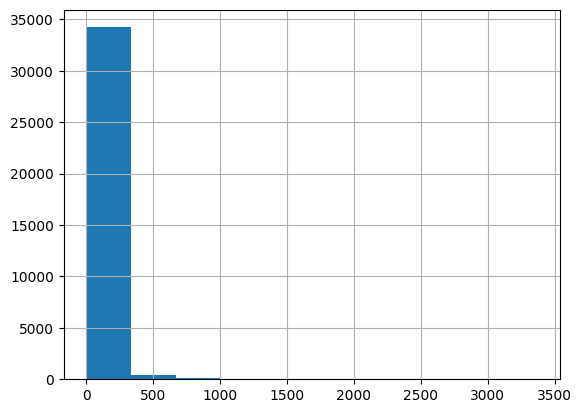

In [68]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist()

The below cells exceed Google's RAM limits. The code above attempts to split tokenization up

In [69]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [70]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

In [71]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    pad_to_max_length=True,
    truncation=True
)

In [72]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())


In [73]:

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())



In [74]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [75]:
del(tokens_train, tokens_test, tokens_val)

In [76]:
gc.collect()

636

In [77]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [79]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [85]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [86]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [87]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [88]:
# compute the class weights
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(train_labels), 
                                     y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [1.36308126 0.78965986]


In [89]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [90]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]
    
    # iterate over batches
    for step, batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [91]:
# function for evaluating the model
def evaluate():
    
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 25 batches.
        if step % 25 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [93]:
# import gc
gc.collect()

49

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



/Users/quinn/opt/anaconda3/envs/PP275/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinn/opt/anaconda3/envs/PP275/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/quinn/opt/anaconda3/envs/PP275/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [ ]:
preds

array([0, 0])